In [1]:
# Import packages
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score, f1_score
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, SMOTENC
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.decomposition import PCA
from scipy import stats
from math import sqrt



import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianNoise
from keras.optimizers import SGD
from keras import regularizers

Using TensorFlow backend.


In [15]:
path = "/Users/Stijn/Documents/Master Data Science and Society/Block 3/thesis/code/thesis_Code/"
mood = pd.read_csv(path+'mood_imputed_median.csv', sep = ',', index_col=0)
mood_anxious = mood.copy()

In [16]:
mood_anxious['anxious'].value_counts()

0.0    7206
1.0    2548
2.0    1946
3.0    1012
4.0     384
5.0     125
Name: anxious, dtype: int64

In [17]:
anxiousR2 = []
for a in mood['anxious']:
    if a == 0:
      anxiousR2.append(0)  
    if a == 1:
      anxiousR2.append(4)
    if a == 2:
      anxiousR2.append(5)
    if a == 3:
      anxiousR2.append(7)
    if a == 4:
      anxiousR2.append(9)
    if a == 5:
      anxiousR2.append(10)
mood_anxious['anxiousR2'] = anxiousR2
mood_anxious = mood_anxious.drop(['anxious'], axis=1)

In [18]:
mood_anxious['anxious_last'] = mood_anxious.groupby('user_id')['anxiousR2'].shift()
mood_anxious.loc[(pd.isnull(mood_anxious.anxious_last)), 'anxious_last'] = mood_anxious['anxiousR2']
mood_anxious = mood_anxious.drop(["content", "bored", "cheerful", "user_id", "response_time"], axis=1)
mood_anxious = mood_anxious[['anxiousR2', 'day_time_window', 'average_TimeUse', 'bulk', 'messaging', 'socialnetworking', 'otherapp', 'anxious_last']]

In [19]:
# Normalize predictors
mood_normz = mood_anxious.copy()
features_to_normalize = ['day_time_window', 'average_TimeUse', 'messaging', 'socialnetworking', 'otherapp']
mood_normz[features_to_normalize] = mood_normz[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [20]:
X = mood_normz.iloc[:,1:]
y = mood_normz.iloc[:, 0:1]
y = y.astype(int)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [22]:
# Oversampling unbalanced target
print("Before OverSampling, counts of labels: {}".format(y_train['anxiousR2'].value_counts()))
  
sm = SMOTENC(categorical_features=[0, 2, 6], random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train['anxiousR2'].ravel()) 

print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res == 4))) 
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res == 5))) 
print("After OverSampling, counts of label '7': {}".format(sum(y_train_res == 7))) 
print("After OverSampling, counts of label '9': {}".format(sum(y_train_res == 9))) 
print("After OverSampling, counts of label '10': {}".format(sum(y_train_res == 10))) 

Before OverSampling, counts of labels: 0     5768
4     2035
5     1576
7      800
9      294
10     103
Name: anxiousR2, dtype: int64
After OverSampling, counts of label '0': 5768
After OverSampling, counts of label '4': 5768
After OverSampling, counts of label '5': 5768
After OverSampling, counts of label '7': 5768
After OverSampling, counts of label '9': 5768
After OverSampling, counts of label '10': 0


In [23]:
X_train = pd.DataFrame(data=X_train_res)
y_train = pd.DataFrame(data=y_train_res)

In [24]:
# Shuffle both train and test set to cancel patterns
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [25]:
X_train_nomood = X_train.iloc[:,:-1]
X_train_onlylastmood = X_train.iloc[:,-1:]
X_test_nomood = X_test.iloc[:,:-1]
X_test_onlylastmood = X_test.iloc[:,-1:]

In [26]:
# Define Keras model
model = Sequential()
model.add(Dense(24, input_dim=6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                168       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(X_train_nomood, y_train, epochs=100, validation_split=0.2, batch_size=512)

Train on 27686 samples, validate on 6922 samples
Epoch 1/100
27686/27686 [==============================] - 0s 10us/step - loss: 42.5789 - accuracy: 0.1498 - val_loss: 38.3654 - val_accuracy: 0.0352
Epoch 2/100
27686/27686 [==============================] - 0s 4us/step - loss: 32.2969 - accuracy: 0.0042 - val_loss: 24.8468 - val_accuracy: 0.0032
Epoch 3/100
27686/27686 [==============================] - 0s 4us/step - loss: 18.5667 - accuracy: 0.0653 - val_loss: 14.0106 - val_accuracy: 0.1066
Epoch 4/100
27686/27686 [==============================] - 0s 5us/step - loss: 12.8500 - accuracy: 0.1157 - val_loss: 12.1698 - val_accuracy: 0.1237
Epoch 5/100
27686/27686 [==============================] - 0s 4us/step - loss: 11.7555 - accuracy: 0.0933 - val_loss: 11.4051 - val_accuracy: 0.0737
Epoch 6/100
27686/27686 [==============================] - 0s 5us/step - loss: 11.2472 - accuracy: 0.0417 - val_loss: 11.0597 - val_accuracy: 0.0134
Epoch 7/100
27686/27686 [==============================]

In [28]:
score = model.evaluate(X_train_nomood, y_train, verbose=0)
print('Test loss:', round(score[0],4))
print('Test accuracy:', round(score[1]*100,2), "%")

Test loss: 10.5189
Test accuracy: 3.9 %


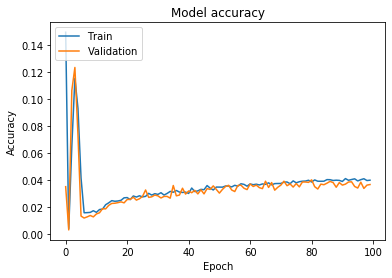

In [29]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

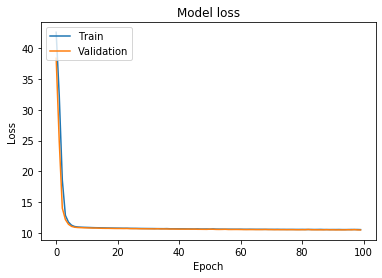

In [30]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [31]:
y_pred = model.predict(X_test_nomood)

In [32]:
cat_list = [0,4,5,7,9,10]
pred = []
for a in y_pred:
    for b in a:
        d = min(cat_list, key=lambda x:abs(x-b))
        pred.append(round(d))    

test = []
for c in y_test['anxiousR2']:
    test.append(c)

In [33]:
test[:5]

[0, 0, 0, 0, 7]

In [34]:
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 12.778827977315691


In [35]:
# true = y_test
# pred = y_pred
# last_value = X_bored_lastarray
same_correct = 0
same_wrong = 0
dif_correct = 0
dif_wrong = 0

X_test_bored = X_test_onlylastmood['anxious_last'].values
for i in range(len(pred)):
    if (test[i] == X_test_bored[i]) and (test[i] == pred[i]):
        same_correct += 1
    if (test[i] == X_test_bored[i]) and (test[i] != pred[i]):
        same_wrong += 1
    if (test[i] != X_test_bored[i]) and (test[i] == pred[i]):
        dif_correct += 1
    if (test[i] != X_test_bored[i]) and (test[i] != pred[i]):
        dif_wrong += 1   

print("       ", "Same", "Dif")
print("correct", same_correct, dif_correct)
print("wrong  ", same_wrong, dif_wrong)

#Check if table is similar to accuracy
if (same_correct+dif_correct) / (same_correct+dif_correct+same_wrong+dif_wrong) == a:
    print("Table is right!")
else:
    print("Table is wrong")

        Same Dif
correct 203 135
wrong   1736 571
Table is right!


In [36]:
from collections import Counter
print("Predicted valxues: ", Counter(pred))
print("True values: ", Counter(test))
print("Previous mood:", Counter(X_test_bored))

Predicted valxues:  Counter({5: 1447, 7: 905, 4: 274, 0: 19})
True values:  Counter({0: 1438, 4: 513, 5: 370, 7: 212, 9: 90, 10: 22})
Previous mood: Counter({0.0: 1418, 4.0: 523, 5.0: 382, 7.0: 222, 9.0: 84, 10.0: 16})


In [39]:
same_correct_0, same_wrong_0, same_correct_1, same_wrong_1, same_correct_2, same_wrong_2, same_correct_3, same_wrong_3, same_correct_4, same_wrong_4, same_correct_5, same_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
dif_correct_0, dif_wrong_0, dif_correct_1, dif_wrong_1, dif_correct_2, dif_wrong_2, dif_correct_3, dif_wrong_3, dif_correct_4, dif_wrong_4, dif_correct_5, dif_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] == 0:
        if test[i] == X_test_bored[i]:
            same_correct_0 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_0 += 1
    if test[i] == 0 and pred[i] != 0:
        if test[i] == X_test_bored[i]:
            same_wrong_0 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_0 += 1

    if test[i] == 4 and pred[i] == 4:
        if test[i] == X_test_bored[i]:
            same_correct_1 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_1 += 1
    if test[i] == 4 and pred[i] != 4:
        if test[i] == X_test_bored[i]:
            same_wrong_1 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_1 += 1
        
    if test[i] == 5 and pred[i] == 5:
        if test[i] == X_test_bored[i]:
            same_correct_2 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_2 += 1
    if test[i] == 5 and pred[i] != 5:
        if test[i] == X_test_bored[i]:
            same_wrong_2 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_2 += 1
    
    if test[i] == 7 and pred[i] == 7:
        if test[i] == X_test_bored[i]:
            same_correct_3 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_3 += 1
    if test[i] == 7 and pred[i] != 7:
        if test[i] == X_test_bored[i]:
            same_wrong_3 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_3 += 1
        
    if test[i] == 9 and pred[i] == 9:
        if test[i] == X_test_bored[i]:
            same_correct_4 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_4 += 1
    if test[i] == 9 and pred[i] != 9:
        if test[i] == X_test_bored[i]:
            same_wrong_4 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_4 += 1
    
    if test[i] == 10 and pred[i] == 10:
        if test[i] == X_test_bored[i]:
            same_correct_5 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_5 += 1
    if test[i] == 10 and pred[i] != 10:
        if test[i] == X_test_bored[i]:
            same_wrong_5 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_5 += 1

print("Total length: ", len(X_test_bored))

print("Same Correct 0 guesses is: ", same_correct_0)
print("Same Wrong 0 guesses is: ", same_wrong_0)
print("Dif Correct 0 guesses is: ", dif_correct_0)
print("Dif Wrong 0 guesses is: ", dif_wrong_0)
print('')
print("Same Correct 1 guesses is: ", same_correct_1)
print("Same Wrong 1 guesses is: ", same_wrong_1)
print("Dif Correct 1 guesses is: ", dif_correct_1)
print("Dif Wrong 1 guesses is: ", dif_wrong_1)
print('')
print("Same Correct 2 guesses is: ", same_correct_2)
print("Same Wrong 2 guesses is: ", same_wrong_2)
print("Dif Correct 2 guesses is: ", dif_correct_2)
print("Dif Wrong 2 guesses is: ", dif_wrong_2)
print('')
print("Same Correct 3 guesses is: ", same_correct_3)
print("Same Wrong 3 guesses is: ", same_wrong_3)
print("Dif Correct 3 guesses is: ", dif_correct_3)
print("Dif Wrong 3 guesses is: ", dif_wrong_3)
print('')
print("Same Correct 4 guesses is: ", same_correct_4)
print("Same Wrong 4 guesses is: ", same_wrong_4)
print("Dif Correct 4 guesses is: ", dif_correct_4)
print("Dif Wrong 4 guesses is: ", dif_wrong_4)
print('')
print("Same Correct 5 guesses is: ", same_correct_5)
print("Same Wrong 5 guesses is: ", same_wrong_5)
print("Dif Correct 5 guesses is: ", dif_correct_5)
print("Dif Wrong 5 guesses is: ", dif_wrong_5)

Total length:  2645
Same Correct 0 guesses is:  13
Same Wrong 0 guesses is:  1235
Dif Correct 0 guesses is:  0
Dif Wrong 0 guesses is:  190

Same Correct 1 guesses is:  32
Same Wrong 1 guesses is:  287
Dif Correct 1 guesses is:  22
Dif Wrong 1 guesses is:  172

Same Correct 2 guesses is:  110
Same Wrong 2 guesses is:  103
Dif Correct 2 guesses is:  83
Dif Wrong 2 guesses is:  74

Same Correct 3 guesses is:  48
Same Wrong 3 guesses is:  70
Dif Correct 3 guesses is:  30
Dif Wrong 3 guesses is:  64

Same Correct 4 guesses is:  0
Same Wrong 4 guesses is:  35
Dif Correct 4 guesses is:  0
Dif Wrong 4 guesses is:  55

Same Correct 5 guesses is:  0
Same Wrong 5 guesses is:  6
Dif Correct 5 guesses is:  0
Dif Wrong 5 guesses is:  16


In [41]:
mae_0, mae_1, mae_2, mae_3, mae_4, mae_5 = (0,0,0,0,0,0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] != 0:
        mae_0 += (abs(test[i]-pred[i]))
    if test[i] == 4 and pred[i] != 4:
        mae_1 += (abs(test[i]-pred[i]))
    if test[i] == 5 and pred[i] != 5:
        mae_2 += (abs(test[i]-pred[i]))
    if test[i] == 7 and pred[i] != 7:
        mae_3 += (abs(test[i]-pred[i]))
    if test[i] == 9 and pred[i] != 9:
        mae_4 += (abs(test[i]-pred[i]))
    if test[i] == 10 and pred[i] != 10:
        mae_5 += (abs(test[i]-pred[i]))

cnt_0, cnt_1, cnt_2, cnt_3, cnt_4, cnt_5 = (0,0,0,0,0,0)
for z in range(len(test)):
    if test[z] == 0:
        cnt_0 += 1
    if test[z] == 4:
        cnt_1 += 1
    if test[z] == 5:
        cnt_2 += 1
    if test[z] == 7:
        cnt_3 += 1
    if test[z] == 9:
        cnt_4 += 1
    if test[z] == 10:
        cnt_5 += 1

mae_macroaverage = ((mae_0/cnt_0) + (mae_1/cnt_1) + (mae_2/cnt_2) + (mae_3/cnt_3) + (mae_4/cnt_4) + (mae_5/cnt_5)) / 6

In [42]:
print("Macro-averaged Mean Absolute error is: ", round(mae_macroaverage, 4))
print("Macro-averaged F1-score is: ", round(f1_score(test, pred, average='weighted'), 4))

Macro-averaged Mean Absolute error is:  2.9076
Macro-averaged F1-score is:  0.0772


/Users/Stijn/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
